### Simple Watershed 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
from skimage.segmentation import clear_border
from PIL import Image

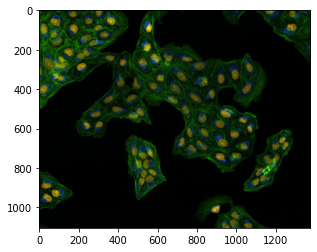

In [2]:
img = cv2.imread('../raw_data/watershed/SimpleExample/Osteosarcoma_01.tif')
plt.imshow(img);

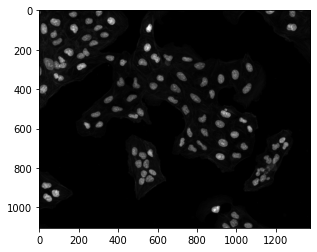

In [3]:
#blue channel, image equivalent to grey image
cell = img[:,:,0]
plt.imshow(cell, cmap='gray');

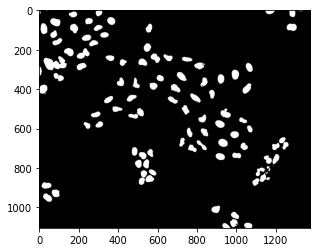

In [4]:
ret1, thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray');

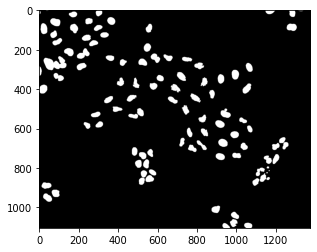

In [5]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
plt.imshow(opening, cmap='gray');

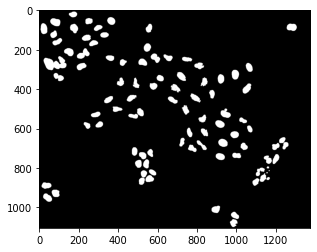

In [6]:
opening = clear_border(opening)
plt.imshow(opening, cmap='gray');

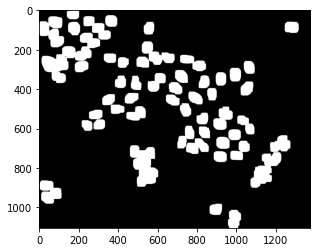

In [7]:
sure_backg = cv2.dilate(opening, kernel, iterations=10)
plt.imshow(sure_backg, cmap='gray');

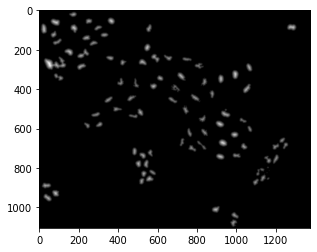

In [8]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap='gray');

In [9]:
dtf_max = dist_transform.max()
print(dtf_max)

21.968996


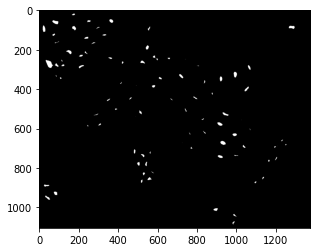

In [10]:
ret2, sure_foreg = cv2.threshold(dist_transform, 0.5*dtf_max, 255, 0)
plt.imshow(sure_foreg, cmap='gray');

In [11]:
sure_foreg = np.uint8(sure_foreg)

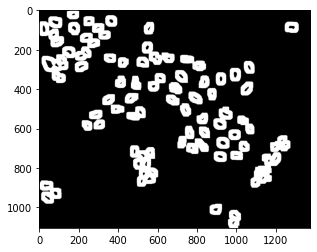

In [12]:
unknown = cv2.subtract(sure_backg,sure_foreg)
plt.imshow(unknown, cmap='gray');

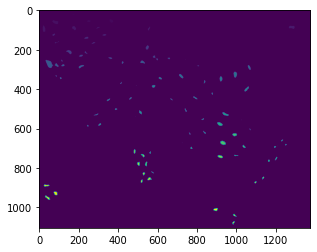

In [13]:
ret3, markers = cv2.connectedComponents(sure_foreg)
plt.imshow(markers);

In [14]:
#background pixel value 0 --> problem
#watershed would consider this as unknown 
#add 10 to all labels so that background is not 0 
markers = markers+10

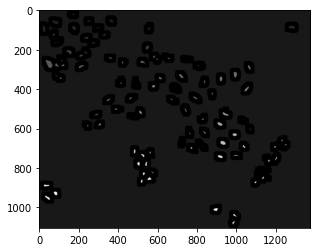

In [15]:
#mark the region of unknown with 0
markers[unknown == 255] = 0
plt.imshow(markers, cmap='gray');

In [16]:
markers = cv2.watershed(img,markers)

In [17]:
img[markers == -1] = [0,255,255]

In [18]:
img2 = color.label2rgb(markers, bg_label=0)

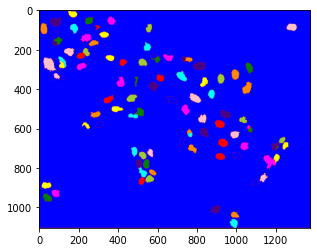

In [19]:
plt.imshow(img2);

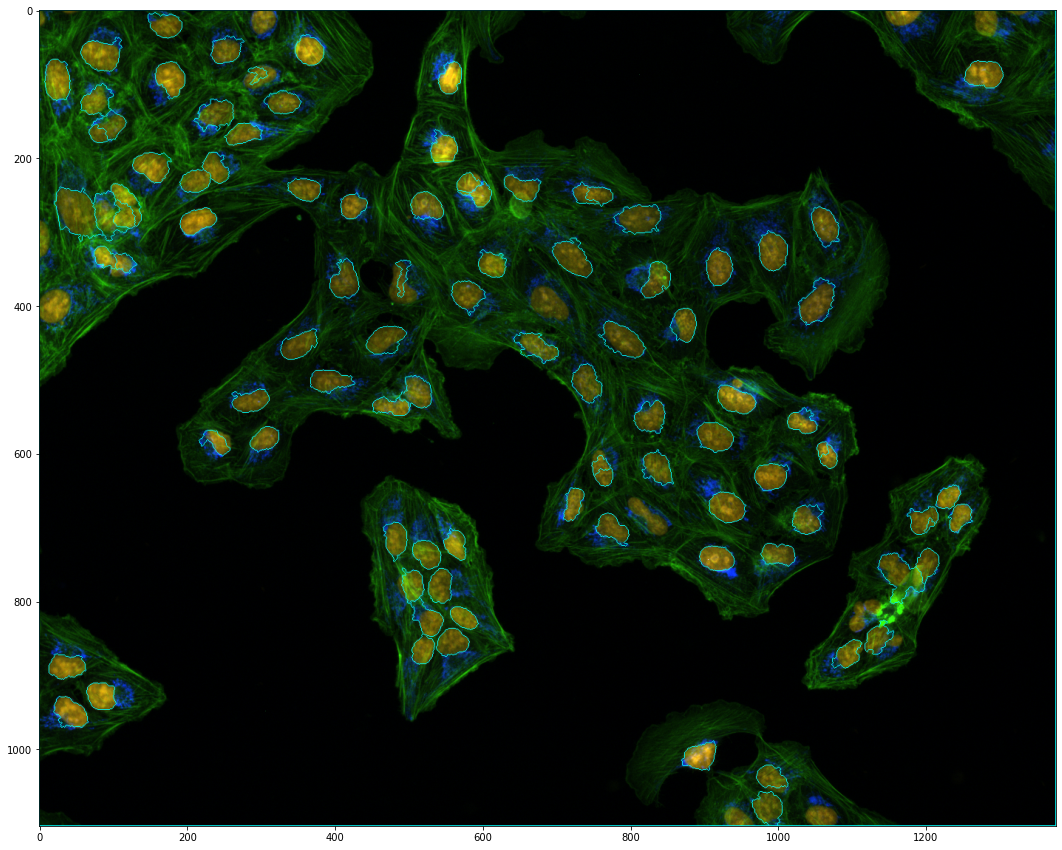

In [20]:
plt.figure(figsize=(20,15))
plt.imshow(img);

### Blood smear 

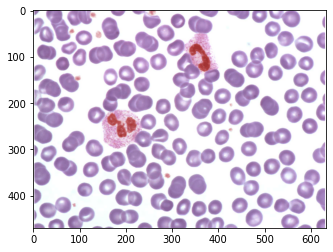

In [21]:
rbc = cv2.imread('../raw_data/watershed/SimpleExample/bloodsmear.png')                
plt.imshow(rbc);

In [67]:
#convert to grayscale 
gray = cv2.cvtColor(im_pre, cv2.COLOR_BGR2GRAY)
Image.fromarray(gray)

error: OpenCV(4.5.4) /tmp/pip-req-build-24v3eisa/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


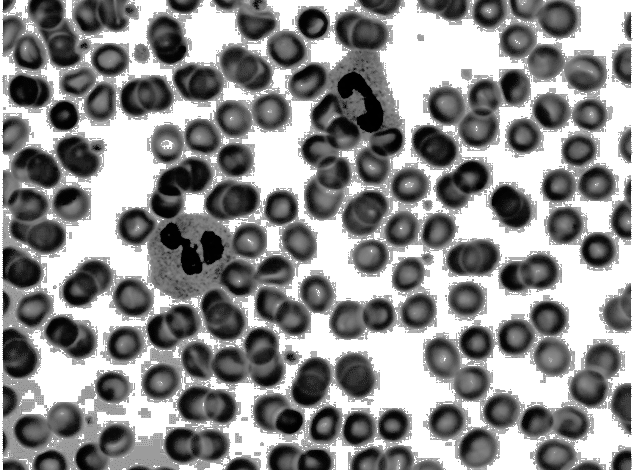

In [23]:
#equalizing the image 
darker = cv2.equalizeHist(gray)
Image.fromarray(darker)

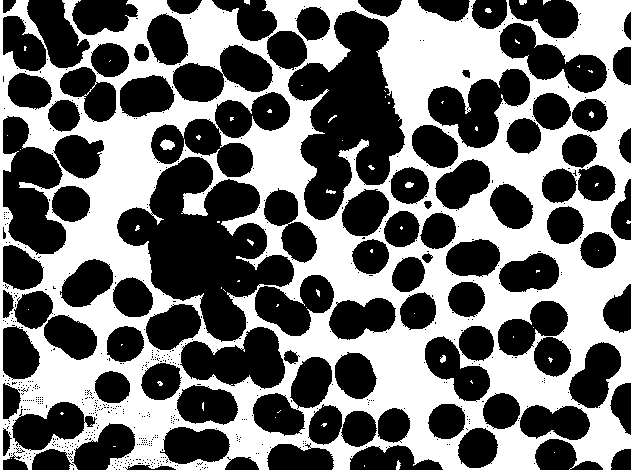

In [24]:
#threshold
ret,thresh = cv2.threshold(darker,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
Image.fromarray(thresh)

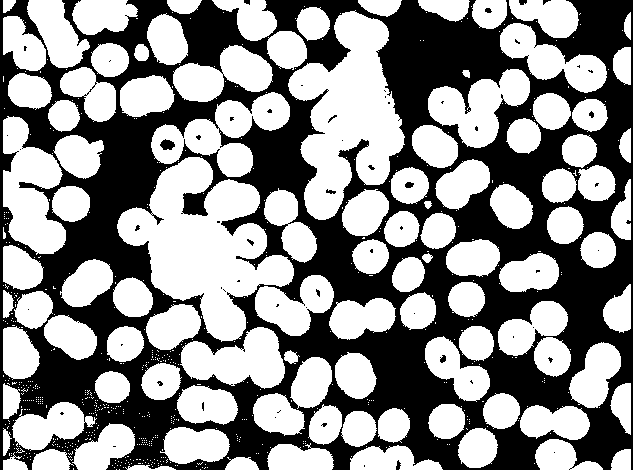

In [25]:
newimg = cv2.bitwise_not(thresh)
Image.fromarray(newimg)

In [68]:
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(im_pre, cv2.MORPH_OPEN, kernel)
Image.fromarray(opened)

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=633x470 at 0x7F7B702FB6A0>

In [27]:
contours, hierarchy = cv2.findContours(opened,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

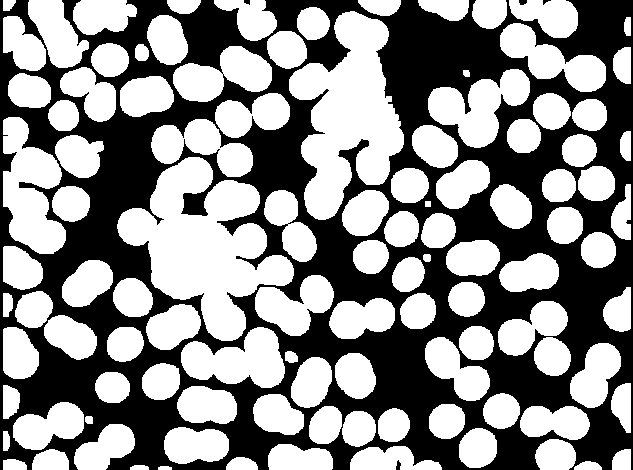

In [28]:
for cnt in contours:
    cv2.drawContours(opened,[cnt],0,255,-1)
Image.fromarray(opened)

In [36]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(opened)
localMax = peak_local_max(D, indices=False, min_distance=15,labels=opened)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=opened)

/tmp/ipykernel_1597/285672976.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=15,labels=opened)
/home/moe/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


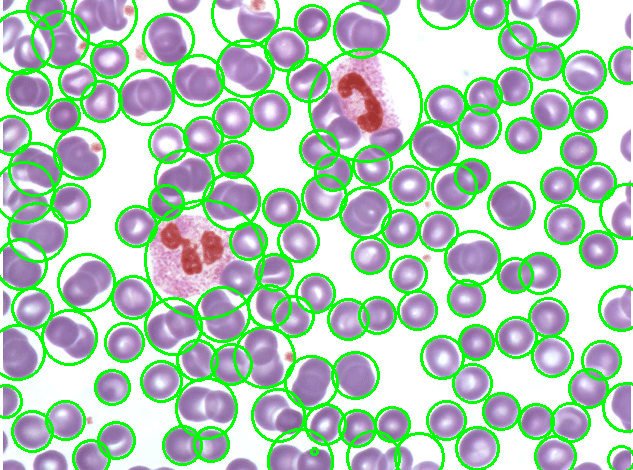

In [30]:
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)
 
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(rbc, (int(x), int(y)), int(r), (0, 255, 0), 2)

Image.fromarray(rbc)

# Preprocessing

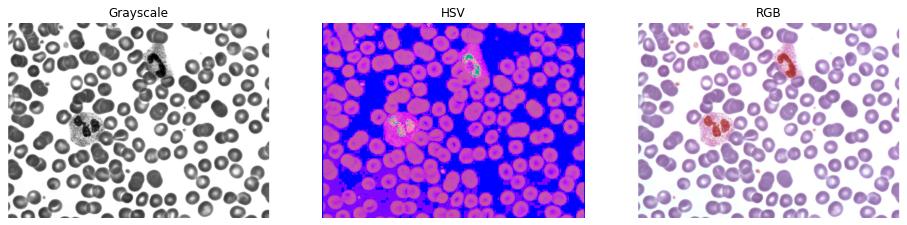

In [37]:
from skimage.color import rgb2hsv
from skimage.color import rgb2gray

rc = cv2.imread('../raw_data/watershed/SimpleExample/bloodsmear.png')

rc_gray = rgb2gray(rc)
rc_hsv = rgb2hsv(rc)

plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(rc_gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale")
plt.subplot(1,3,2)
plt.imshow(rc_hsv)
plt.axis("off")
plt.title("HSV")
plt.subplot(1,3,3)
plt.imshow(rc)
plt.axis("off")
plt.title("RGB");

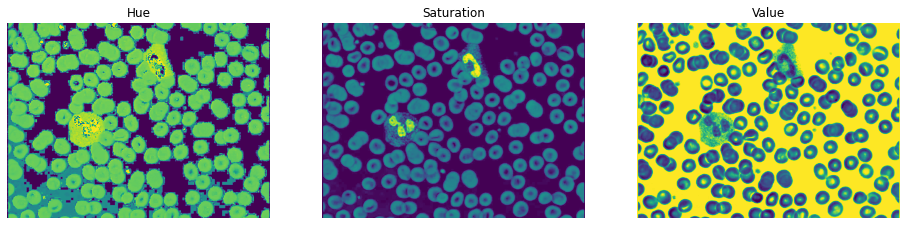

In [40]:
rc_hue = rc_hsv[:,:,0]
rc_sat = rc_hsv[:,:,1]
rc_value = rc_hsv[:,:,2]


plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(rc_hue)
plt.axis("off")
plt.title("Hue")
plt.subplot(1,3,2)
plt.imshow(rc_sat)
plt.axis("off")
plt.title("Saturation")
plt.subplot(1,3,3)
plt.imshow(rc_value)
plt.axis("off")
plt.title("Value");

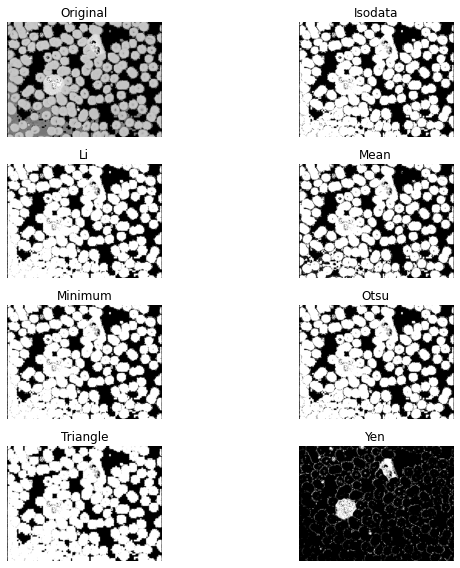

In [41]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(rc_hue, figsize=(10, 8), verbose=False)
plt.show()

In [50]:
from skimage.filters import threshold_yen

rc_yen = threshold_yen(rc_hue)
rc_yen

0.8326605902777777

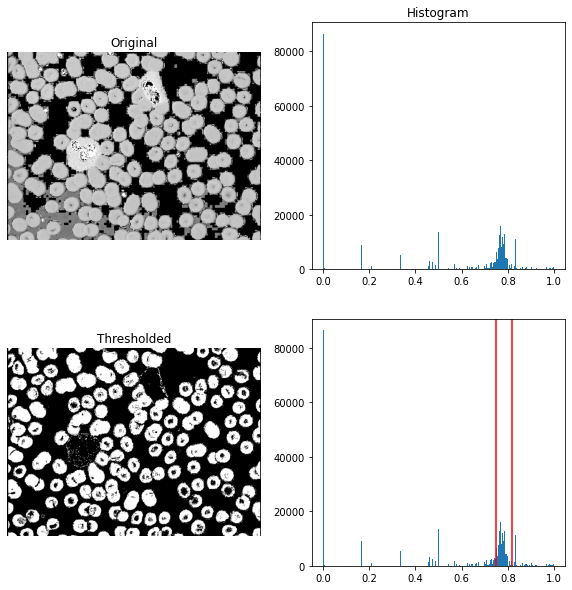

In [59]:
from skimage.filters import threshold_minimum, threshold_otsu, threshold_mean, threshold_isodata, threshold_li, threshold_local
from cv2 import inRange

image = rc_hue


thresh_min = 0.75     #threshold_mean(image)
thresh_max = 0.82

binary = inRange(image, thresh_min, thresh_max) #thresh_max > image > thresh

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap="gray")

ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary, cmap="gray")
ax[1, 0].set_title('Thresholded')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')
ax[1, 1].axvline(thresh_max, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

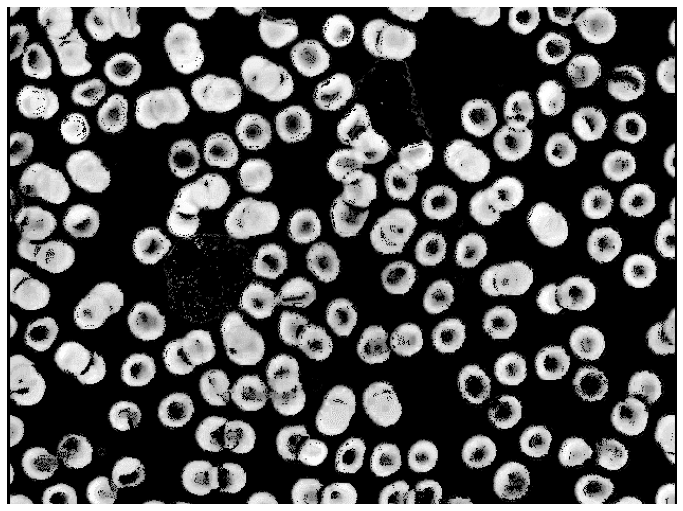

In [66]:


im_pre = binary * rc_hue

plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(im_pre, cmap="gray");